In [1]:
import os
from pathlib import Path
import pymysql
import re
from datetime import datetime
from palettable.colorbrewer.qualitative import Pastel1_7
from datetime import time
import seaborn as sns
import numpy as np
import matplotlib
from konlpy.tag import Kkma
import matplotlib.pyplot as plt
import pandas as pd


DATABASE_NAME = "chats"
HOST_NAME = "localhost"
USER_ID = "root"
USER_PASSWORD = "rootPW1!"
CHARSET = "utf8"
TXT_FOLDER_PATH = "chats"

In [2]:
conn = pymysql.connect(host=HOST_NAME, user=USER_ID, passwd=USER_PASSWORD, charset=CHARSET)
cursor = conn.cursor()

In [3]:
sql = 'USE %s ;'%DATABASE_NAME
cursor.execute(sql)
conn.commit()

In [4]:
sql = 'SELECT * FROM indexes;'
cursor.execute(sql)
conn.commit()
rows=cursor.fetchall()

In [5]:
ls=[]
for row in rows :
    if row[1]<10:
        table_name = str(row[0])+'0'+str(row[1])
    else:
        table_name = str(row[0])+str(row[1])
    sql='SELECT * FROM %schats;' %table_name
    cursor.execute(sql)
    conn.commit()
    results = cursor.fetchall()
    for result in results:
#         print(result)
        item = [result[0], result[0].year, result[0].month, result[0].day, result[0].hour, result[0].minute, result[1], result[2]]
        ls.append(item)

In [6]:
df_origin = pd.DataFrame(ls,columns=['time','year','month','day','hour','minute','sender','message'])

In [7]:
df_origin[df_origin['sender']=='A']
with open ('a_words .txt','w') as f :
    f.write('\n'.join(df_origin[df_origin['sender']=='A']['message']))

In [8]:
def autopct_generator(limit):
    def inner_autopct(pct):
        return ('%.2f%%' % pct) if pct > limit else ''
    return inner_autopct

In [9]:
def label_generator(dic, limit):
    new_values=[]
    keys=dic.keys()
    values=dic.values()
    total=np.sum(list(values))
    for i in range(len(keys)):
        if (list(values)[i]*100/total) > limit:
            new_values.append(list(keys)[i])
        else :
            new_values.append('')
    return new_values

In [10]:
def printPie(dic, title,exp=0.03, fig=[12,6], min_pct=0):
    plt.rc('font', family='NanumSquare_ac')
    fig, ax = plt.subplots(figsize=fig)
    # Create a circle at the center of the plot
    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(x=dic.values(), autopct=autopct_generator(min_pct), explode=[exp]*len(dic.keys()), 
            labels=label_generator(dic,min_pct),colors=Pastel1_7.hex_colors)
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title(title, fontsize=14);

In [11]:
def printPies(dics,main_title, titles, row, cols, exp=0.03,colsfig=[12,6], min_pct=0):
    plt.rc('font', family='NanumSquare_ac')
    axs = [0 for _ in range(row*col)] 
    fig, = plt.subplots(2,2)
    for i,dic in enumerate(dics):
        plt.figure(i)
        plt.pie(x=dic.values(), autopct=autopct_generator(min_pct), explode=[exp]*len(dic.keys()), 
                labels=label_generator(dic,min_pct))
        plt.title(title, fontsize=14);
    plt.show()

In [12]:
def makeDict(df, col):
    k=np.sort(df[col].unique())
    v=[0 for _ in range(len(k))]
    for data in df[col]:
        i=list(k).index(data)
        v[i]+=1
    dic=dict(zip(k,v))
    return dic

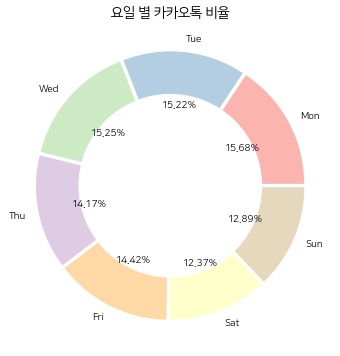

In [13]:
weekdays=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
weekdays_cnt=[0 for _ in range(7)]
for t in df_origin['time']:
    name=t.strftime('%a')
    i=weekdays.index(name)
    weekdays_cnt[i]+=1
d = dict(zip(weekdays, weekdays_cnt))
printPie(d, '요일 별 카카오톡 비율')
del d,weekdays,weekdays_cnt

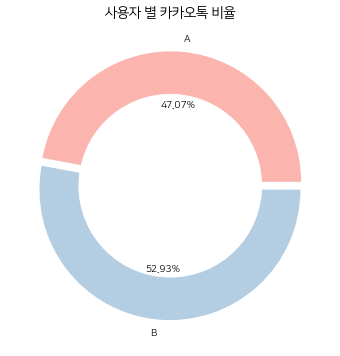

In [14]:
d = makeDict(df_origin,'sender')
printPie(d,'사용자 별 카카오톡 비율')
del d

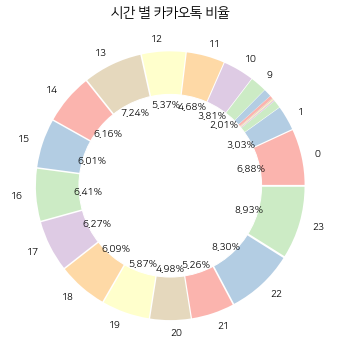

In [15]:
d=makeDict(df_origin,'hour')
printPie(d,'시간 별 카카오톡 비율',min_pct=2)
del d

In [16]:
def trans_pertentage_dict(dic):
    new_dic={}
    s = sum(dic.values())
    for k, v in dic.items():
        pct = v * 100.0 / s
        new_dic[k]=pct
    return new_dic

In [17]:
def plot_multilines(df,by, hue, hue_ls,color, title):
    plt.rc('font', family='NanumSquare_ac')
    fig, ax = plt.subplots(figsize=(12,6))
    for i,h in enumerate(hue_ls):
        d=makeDict(df[df[hue]==h],by)
        d=trans_pertentage_dict(d)
        g=sns.lineplot(x=d.keys(),y=d.values(), data=d,color=color[i])
    g.set_ylabel("빈도 수(%)")
    g.set_xticks(range(len(df[by].unique())))
    plt.title(title)
    g.legend(hue_ls)

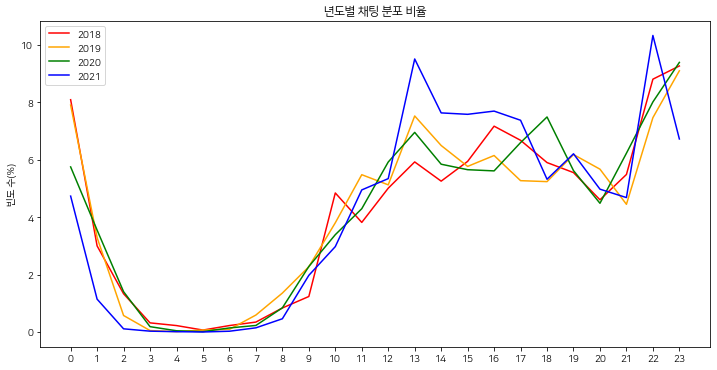

In [18]:
plot_multilines(df_origin,'hour','year',[2018,2019,2020,2021],['red','orange','green','blue'],"년도별 채팅 분포 비율")

In [19]:
def plot_countplot(df, title, x_name, hue_name=''):
    plt.rc('font', family='NanumSquare_ac')
    fig, ax = plt.subplots(figsize=(12,6))
    sns.set_style('ticks')
    if hue_name!='':
        g=sns.countplot(x=x_name, hue=hue_name,palette='Pastel1', data=df)
    else:
        g=sns.countplot(x=x_name,palette='Pastel1', data=df)
    plt.title(title)
    plt.show() 

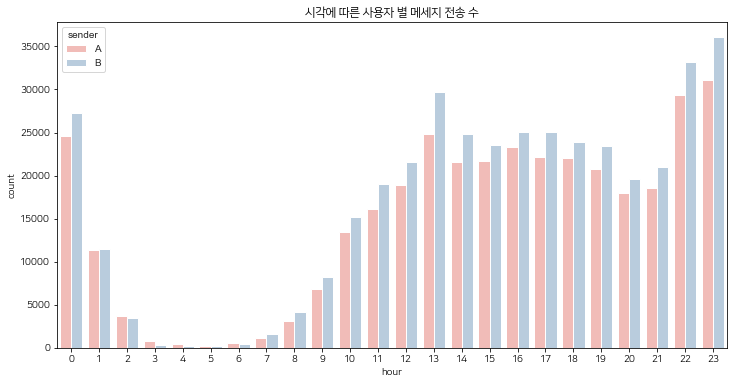

In [20]:
plot_countplot(df_origin, '시각에 따른 사용자 별 메세지 전송 수', 'hour','sender')

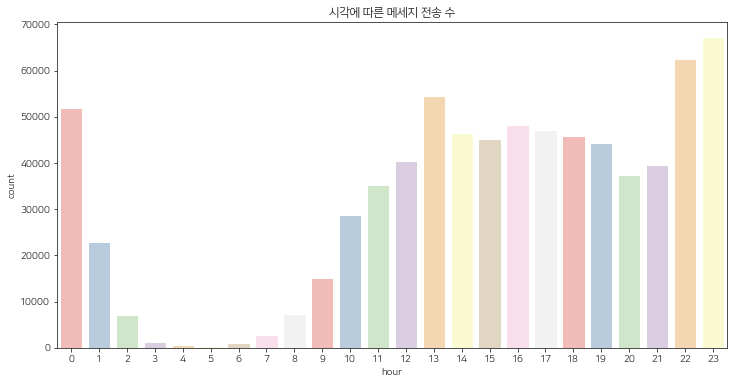

In [21]:
plot_countplot(df_origin, '시각에 따른 메세지 전송 수', 'hour')